In [1]:
# Imports
        
import os
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from datetime import datetime


# Constants
DATA_DIR = "probe_data_map_matching"

link_headers = ["linkPVID", 
                "refNodeID", 
                "nrefNodeID", 
                "length", 
                "functionalClass", 
                "directionOfTravel", 
                "speedCategory", 
                "fromRefSpeedLimit", 
                "toRefSpeedLimit", 
                "fromRefNumLanes", 
                "toRefNumLanes", 
                "multiDigitized", 
                "urban", 
                "timeZone", 
                "shapeInfo", 
                "curvatureInfo", 
                "slopeInfo"]

In [2]:
# Read in the Link Data
link_data = pd.read_csv(os.path.join(DATA_DIR, "Partition6467LinkData.csv"), header=None, names=link_headers)
link_data.drop('curvatureInfo', axis=1, inplace=True)

print(link_data.shape)

link_data.head()

(200089, 16)


,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,slopeInfo
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,0.0,51.4965800/9.3862299/|51.4994700/9.3848799/,NaN
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,0.0,51.4965800/9.3862299/|51.4966899/9.3867100/|51...,NaN
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4965800/9.3862299/,NaN
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4990000/9.3836099/,NaN
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.0,53.0643099/8.7903400/45.79|53.0650299/8.791470...,0.00/-0.090|110.17/0.062


In [3]:
# how many have slope info?
link_data.dropna().shape

(53517, 16)

In [4]:
# Actually get rid of the missings
link_data.dropna(inplace=True)

In [5]:
# Read in the (Matched) Probe Data

probe_data = pd.read_csv(os.path.join(DATA_DIR, "matched_probes.csv"))

probe_data['dateTime'] = pd.to_datetime(probe_data['dateTime'], format='%m/%d/%Y %I:%M:%S %p')
#print(probe_data.head)
#probe_data['dateTime'] = pd.to_datetime(probe_data['dateTime'], format='%Y-%m-%d %H:%M:%S')
probe_data.to_pickle(os.path.join(DATA_DIR, 'converted_probe_linked_data.pickle'))

probe_data = pd.read_pickle(os.path.join(DATA_DIR, 'converted_probe_linked_data.pickle'))

In [6]:
probe_data.shape

(407, 12)

In [7]:
# How many unique linkPVID's are contained in the matched probe data
print("Roughly what do the Groups look like?")
itr = 0
for i in probe_data.groupby('linkPVID').groups:
    if itr <= 5:
        print(i, probe_data.groupby('linkPVID').groups[i])
        itr += 1

print("There are {} Unique linkPVID's represented".format(len(probe_data.groupby('linkPVID').groups)))

Roughly what do the Groups look like?
51754646 Int64Index([118, 119, 120, 121, 122, 123, 254, 255, 256, 257, 258, 259, 390,
            391, 392, 393, 394, 395],
           dtype='int64')
51790471 Int64Index([0, 135, 136, 271, 272], dtype='int64')
51790473 Int64Index([1, 2, 3, 137, 138, 139, 273, 274, 275], dtype='int64')
51924236 Int64Index([15, 16, 151, 152, 287, 288], dtype='int64')
572222029 Int64Index([29, 165, 301], dtype='int64')
67946254 Int64Index([ 83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
             96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
            109, 110, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
            230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
            243, 244, 245, 246, 355, 356, 357, 358, 359, 360, 361, 362, 363,
            364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376,
            377, 378, 379, 380, 381, 382],
           dtype='int64')
There are 24 Unique

So, 189621 Unique PVID's are covered. Given that there are roughly 200,000 links in the dataset, this level of coverage is actually quite good.

In [8]:
joined_data = probe_data.join(link_data.set_index('linkPVID'), on='linkPVID', how='inner', lsuffix='l', rsuffix='r')


In [9]:
joined_data.head()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading,linkPVID,direction,...,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,slopeInfo
0,21065,2009-06-26 11:48:20,13,51.369864,9.636753,438,36,57,51790471,T,...,4,999,999,1,1,F,F,0.0,51.3695899/9.6361500/431.59|51.3698300/9.63660...,0.00/-0.150|41.14/-0.966|62.96/-1.369|74.30/-1...
135,21065,2009-06-26 11:48:15,13,51.369613,9.636300,438,22,78,51790471,F,...,4,999,999,1,1,F,F,0.0,51.3695899/9.6361500/431.59|51.3698300/9.63660...,0.00/-0.150|41.14/-0.966|62.96/-1.369|74.30/-1...
136,21065,2009-06-26 11:48:20,13,51.369864,9.636753,438,36,57,51790471,T,...,4,999,999,1,1,F,F,0.0,51.3695899/9.6361500/431.59|51.3698300/9.63660...,0.00/-0.150|41.14/-0.966|62.96/-1.369|74.30/-1...
271,21065,2009-06-26 11:48:15,13,51.369613,9.636300,438,22,78,51790471,F,...,4,999,999,1,1,F,F,0.0,51.3695899/9.6361500/431.59|51.3698300/9.63660...,0.00/-0.150|41.14/-0.966|62.96/-1.369|74.30/-1...
272,21065,2009-06-26 11:48:20,13,51.369864,9.636753,438,36,57,51790471,T,...,4,999,999,1,1,F,F,0.0,51.3695899/9.6361500/431.59|51.3698300/9.63660...,0.00/-0.150|41.14/-0.966|62.96/-1.369|74.30/-1...


In [10]:
print("And now after the join and NA removal, we have {} rows of data".format(joined_data.shape[0]))

And now after the join and NA removal, we have 407 rows of data


In [11]:
def rolling_diff(df):
    return df[-1] - df[0]

cleaned_joined_data = joined_data.dropna()

cleaned_joined_data['avg_link_slope'] = cleaned_joined_data['slopeInfo'].apply(lambda x: np.mean([float(i.split('/')[1]) for i in x.split('|')]))

gdf = cleaned_joined_data.groupby('sampleID')
cleaned_joined_data['delta_elevation'] = gdf['altitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_latitude'] = gdf['latitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_longitude'] = gdf['longitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_speed'] = gdf['speed'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['rolling_slope'] = cleaned_joined_data['delta_elevation'] / np.sqrt(cleaned_joined_data['delta_latitude'] ** 2 + cleaned_joined_data['delta_longitude'] ** 2)
cleaned_joined_data['rolling_acc'] = cleaned_joined_data['delta_speed'] / np.sqrt(cleaned_joined_data['delta_latitude'] ** 2 + cleaned_joined_data['delta_longitude'] ** 2)

cleaned_joined_data = cleaned_joined_data.dropna()


In [12]:

cleaned_joined_data['speed_limit_diff'] = cleaned_joined_data['speed'] - cleaned_joined_data['fromRefSpeedLimit']

cleaned_joined_data['multiDigitized'] = cleaned_joined_data['multiDigitized'].apply(lambda x: 1 if x in 'T' else 0)



C:\Users\Pumpkin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pumpkin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
feature_set = [#'sampleID',
                   #'dateTime',
                   'altitude',
                    'latitude', 
                    'longitude',
                   'speed', 
                   'heading', 
                   'length',
                   #'functionalClass',
                   #'fromRefSpeedLimit',
                    'speed_limit_diff',
                   #'toRefSpeedLimit', 
                   #'fromRefNumLanes', 
                   #'toRefNumLanes',
                    #'multiDigitized',
                    #'delta_elevation',
                    'distFromLink',
                    'delta_speed',
                    'rolling_acc',
                    'rolling_slope',
                   'avg_link_slope']

subset = cleaned_joined_data[feature_set]

print(subset.shape)
import sklearn
train, test = sklearn.model_selection.train_test_split(subset, test_size = 0.2, random_state=1)


dtrain = xgb.DMatrix(train.values[:,:-1], train.values[:,-1], feature_names = feature_set[:-1])
dtest = xgb.DMatrix(test.values[:,:-1], test.values[:,-1], feature_names = feature_set[:-1])
param = {'max_depth':10, 'eta':0.2, 'silent':1, "lambda": 1.2, "objective": "reg:linear", "booster":"gbtree" }
param['nthread'] = 63
param['eval_metric'] = 'rmse'
evallist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 200
bst = xgb.train( param, dtrain, num_round, evallist, early_stopping_rounds=10)


(386, 12)
[0]	eval-rmse:0.888211	train-rmse:0.955329
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:0.721246	train-rmse:0.775686
[2]	eval-rmse:0.584717	train-rmse:0.630348
[3]	eval-rmse:0.473391	train-rmse:0.511738
[4]	eval-rmse:0.383244	train-rmse:0.415745
[5]	eval-rmse:0.310185	train-rmse:0.338659
[6]	eval-rmse:0.251898	train-rmse:0.275722
[7]	eval-rmse:0.204844	train-rmse:0.22504
[8]	eval-rmse:0.166288	train-rmse:0.184149
[9]	eval-rmse:0.135252	train-rmse:0.151011
[10]	eval-rmse:0.110817	train-rmse:0.123797
[11]	eval-rmse:0.090826	train-rmse:0.101845
[12]	eval-rmse:0.074555	train-rmse:0.083768
[13]	eval-rmse:0.061268	train-rmse:0.069113
[14]	eval-rmse:0.050431	train-rmse:0.057108
[15]	eval-rmse:0.041624	train-rmse:0.04716
[16]	eval-rmse:0.034576	train-rmse:0.039082
[17]	eval-rmse:0.029032	train-rmse:0.032333
[18]	eval-rmse:0.024611	train-rmse:0.026901
[19]	eval-rmse:0.0206

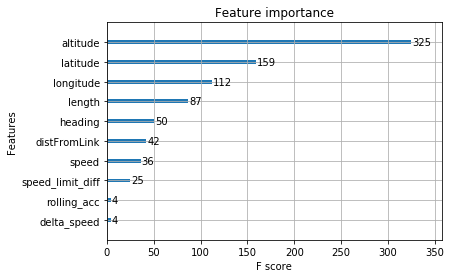

In [14]:
xgb.plot_importance(bst)

C:\Users\Pumpkin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


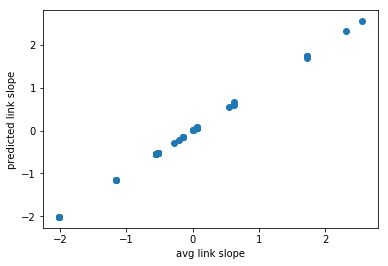

In [15]:
preds = bst.predict(dtest)
zipped_preds = test
zipped_preds['preds'] = preds

plt.figure()
plt.scatter(zipped_preds['avg_link_slope'], zipped_preds['preds'])
plt.xlabel('avg link slope')
plt.ylabel('predicted link slope')
plt.show()

In [19]:
zipped_preds.to_csv('slope.csv')